# Logistic Regression
**CS 4650 "Natural Language Processing" Project 0**  
Georgia Tech, Spring 2022 
   
In this assignment, we will walk you through the process of implementing logistic regression from scratch. You will also apply your implemented logistic regression model to a small dataset and predict whether a student will be admitted to a university. This dataset will allow you to visualize the data and debug more easily. You may find [this documentation](http://socialmedia-class.org/slides/AndrewNg_ex2.pdf) very helpful, though it is about how to implement logistic regression in Octave.

This assignment also serves as a programming preparation test. We will use [Numpy](https://numpy.org/doc/stable/user/quickstart.html) -- a popular Python package for scientific computing and implementing machine learning algorithms. It provides very good support for matrix and vector operations. You need to feel comfortable working with matrics, vectors, and tensors in order to complete all the programming projects in CS 4650. 

To start, first make a copy of this notebook to your local drive, so you can edit it. 

<div class="alert alert-danger">
IMPORTANT: In this assignment, except Numpy and Matplotlib, no other external Python packages are allowed. Scipy package can be used in gradient checking, though, it is not allowed elsewhere. 
</div>

## 0. Honor Code  [1 points]

**Honor Code:** I hereby agree to abide the Georgia Tech's Academic Honor Code, promise that the submitted assignment is my own work, and understand that my code is subject to plagiarism test.

**Signature**: *(double click on this block and type your name here)*

## 1. Importing Numpy and Matplotlib [Code provided - do not change]

In [171]:
import sys

# Check what version of Python is running
print (sys.version)

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]




We will also import [Matplotlib](http://matplotlib.org/users/pyplot_tutorial.html), a Python package for data visualization.  

In [172]:
# Run some setup code for this notebook. Don't modify anything in this cell.

import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# reload external python modules;
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Visualizing the Data  [Code provided - no need to change]

Go ahead download the data file ([p0_data.txt](https://github.com/cocoxu/CS4650_projects_sp2022/blob/master/p0/p0_data.txt)) from the course GitHub repo, then upload to Google Colab using the files panel on the left (click the last icon on the menu). 

The provided dataset contains applicants' scores on two exams and the admission decisons for 100 students. This dataset will allow us to visualize in a 2D figure and showcase how the logistic regression algorithm works more intuitively. 

# of training examples =  100
# of features =  2


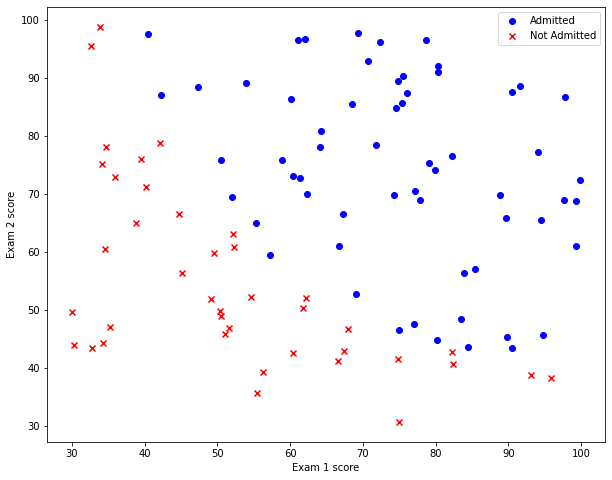

In [173]:

#load the dataset
data = np.loadtxt('p0_data.txt', delimiter=',')

train_X = data[:, 0:2]
train_y = data[:, 2]

# Get the number of training examples and the number of features
m_samples, n_features = train_X.shape
print ("# of training examples = ", m_samples)
print ("# of features = ", n_features)

pos = np.where(train_y == 1)
neg = np.where(train_y == 0)
plt.scatter(train_X[pos, 0], train_X[pos, 1], marker='o', c='b')
plt.scatter(train_X[neg, 0], train_X[neg, 1], marker='x', c='r')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted', 'Not Admitted'])
plt.show()

## 3. Cost Function [5 points]
You're going to first implement the sigmoid function, then the cost function for (binary) logistic regression. 

The sigmoid function is defined as $sigmoid(\mathbf{z}) = \frac{1}{1+{e^{-\mathbf{z}}}}$.

Note that, you are asked to use the [Numpy](https://numpy.org/doc/stable/user/quickstart.html) package for vector and matrix operations in order to ensure the __efficiency of the code__. 

In [174]:
def sigmoid(z):
    """ Sigmoid function """
    ###################################################################
    # Compute the sigmoid function for the input here.                #
    ###################################################################
    sig = None    
    
    ### YOUR CODE HERE: be careful of the potential underflow or overflow here

    # z.astype(my_type) converts np.array (which is z) to specified data type(which is my_type)
    # using np.piecewise without changing the data type will return int typed value which truncates all the decimal points
    z = np.array(z)
    sig = np.piecewise(
        z.astype(float),
        [z > 0],
        [lambda x: 1/(1 + np.exp(-x)), lambda x: np.exp(x)/(1 + np.exp(x))],
    )
    
    ### END YOUR CODE
    return sig

# Check your sigmoid implementation
z = np.array([[1, 2], [-1, -2]])
f = sigmoid(z)
print (f)

[[0.73105858 0.88079708]
 [0.26894142 0.11920292]]


In [177]:
from scipy.optimize.nonlin import Jacobian
def cost_function(theta, X, y):
    """ The cost function for logistic regression """
    #####################################################################################
    # Compute the cost given the current parameter theta on the training data set (X, y)#
    #####################################################################################
    cost = None

    ### YOUR CODE HERE

    m = y.shape[0]
    # compute sigmoid(activation), @: equivalent to matmul (can replace np.dot())
    h = sigmoid(X @ theta)
    # clip values that is close to either 0 or 1
    h = np.where(h < 1/np.power(10, 7), 1/np.power(10, 7), h)
    h = np.where(h == 1, 0.9, h)

    # compute cost
    J = (1/(m))*( -(y @ np.log(h)) - ((np.subtract(1, y)) @ np.log(np.subtract(1, h))) )

    cost = J
   
    ### END YOUR CODE
    return cost

# Check your cost function implementation

t_X = np.array([[1, 2], [-1, -2]])
t_y = np.array([0, 1])
t_theta1 = np.array([-10, 10])
t_theta2 = np.array([10, -10])
t_c1 = cost_function(t_theta1, t_X, t_y)
t_c2 = cost_function(t_theta2, t_X, t_y)
print (t_c1)
print (t_c2)

10.000045398899701
4.539889921682063e-05


## 4. Gradient Computation [5 points]

Implement the gradient computations for logistic regression. 

In [178]:
def gradient_update(theta, X, y):
    """ The gradient update for logistic regression"""
    ###############################
    # Compute the gradient update #
    ###############################
    grad = None

    ### YOUR CODE HERE

    m = y.shape[0]
    # compute sigmoid (activation)
    h = sigmoid(X @ theta)
    # clip values that is close to either 0 or 1
    h = np.where(h < 1/np.power(10, 7), 1/np.power(10, 7), h)
    h = np.where(h == 1, 0.9, h)

    # compute gradient
    grad = (1/m)*( np.subtract(h, y) @ X )

    ### END YOUR CODE
    return grad

# Check your gradient computation implementation
t_X = np.array([[1, 2, 3]
                , [-1, -2, -3]])
t_y = np.array([0
                , 1])
t_theta1 = np.array([-10, 10, 0])
t_theta2 = np.array([10, -10, 0])
t_g1 = gradient_update(t_theta1, t_X, t_y)
t_g2 = gradient_update(t_theta2, t_X, t_y)
print (t_g1)
print (t_g2)

[0.9999546  1.9999092  2.99986381]
[4.53978687e-05 9.07957374e-05 1.36193606e-04]


## 5. Gradient Checking [Code provided. Bonus 5 points if implemented from scratch]
You can use the code provided below to check the gradient of your logistic regression functions using [Scipy](https://docs.scipy.org/doc/scipy/tutorial/index.html) package. Alternatively, you can implement the gradient checking from scratch by yourself (bonus 5 points). 

[Gradient checking](http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/) is an important technique for debugging the gradient computation. Logistic regression is a relatively simple algorithm where it is straightforward to derive and implement its cost function and gradient computation. For more complex models, the gradient computation can be notoriously difficulty to debug and get right. Sometimes a subtly buggy implementation will manage to learn something that can look surprisingly reasonable, while performing less well than a correct implementation. Thus, even with a buggy implementation, it may not at all be apparent that anything is amiss. 

In [179]:
# Check your gradient computation implementation
t_samples, t_features = 100, 10
t_X = np.random.randn(t_samples, t_features)
t_y = np.random.randint(2, size=t_samples) 
t_theta = np.random.randn(t_features)

from scipy import optimize
print('Output of check_grad: %s' % optimize.check_grad(cost_function, gradient_update, t_theta, t_X, t_y))

Output of check_grad: 5.873057271457153e-07


## 6. Gradient Descent  and Decision Boundary  [10 points]

Implement the batch gradient decent algorithm for logistic regression. For every 'print_iterations' number of iterations, also visualize the decision boundary and observe how it changes during the training.

Note that, you will need to carefully choose the learning rate and the total number of iterations (you may want to use a small learning rate and a very large number of interations), given that the starter code does not include feature scaling (e.g., scale each feature by its maximum absolute value to convert feature value to [-1,1] range -- in order to make this homework simple and easier for you to write code to visualize. 

[ Iteration 1 ] cost = 9.882089631393361


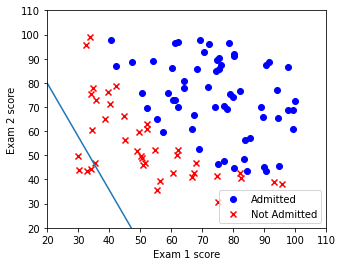

[ Iteration 100000 ] cost = 5.753287141118459


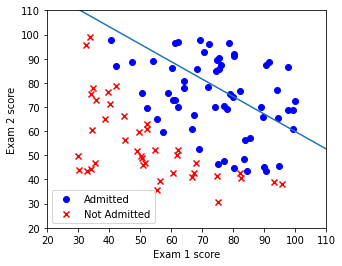

[ Iteration 200000 ] cost = 1.213228740651145


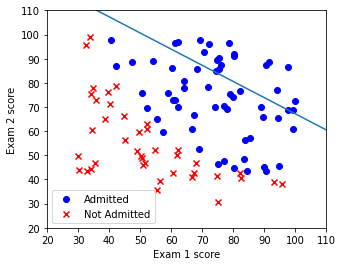

[ Iteration 300000 ] cost = 0.32559540179343516


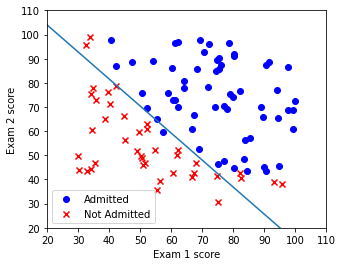

[ Iteration 400000 ] cost = 0.26031596447719835


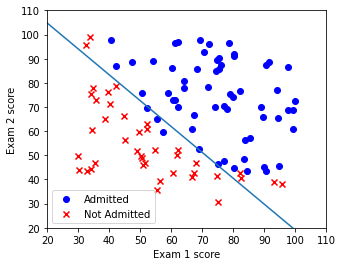

[ Iteration 500000 ] cost = 0.23803815010274249


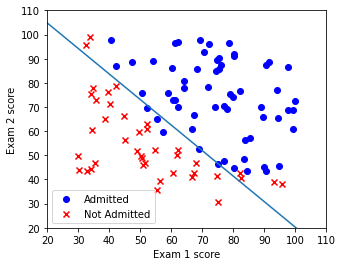

[ Iteration 600000 ] cost = 0.2268661270157376


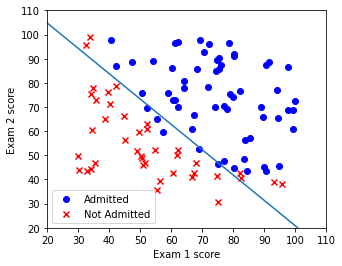

[ Iteration 700000 ] cost = 0.2202606301266224


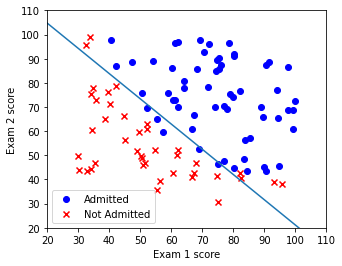

[ Iteration 800000 ] cost = 0.21597848366028452


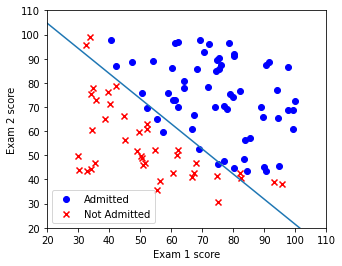

[ Iteration 900000 ] cost = 0.2130340160810004


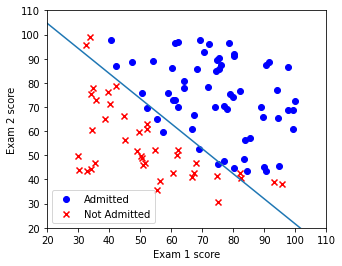

[ Iteration 1000000 ] cost = 0.2109247106294336


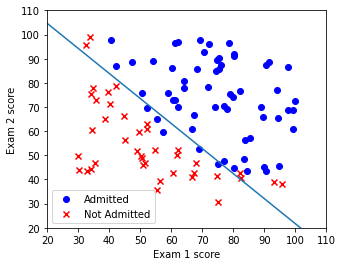

In [200]:

def gradient_descent(theta, X, y, alpha, max_iterations, print_iterations):
    """ Batch gradient descent algorithm """
    #################################################################
    # Update the parameter 'theta' iteratively to minimize the cost #
    # Also visualize the decision boundary during learning          #
    #################################################################
 
    alpha *= X.shape[0] #m_samples
    iteration = 0
    
    ### YOUR CODE HERE:
    bias = 5
    X_copy = np.array([np.append(X_i, bias) for X_i in X])
    theta = np.append(theta, 15)
    
    ### END YOUR CODE

    while(iteration < max_iterations):
        iteration += 1
        
        ### YOUR CODE HERE: simultaneous update of partial gradients
        grad = gradient_update(theta, X_copy, y)
        theta = theta - alpha*grad

        ### END YOUR CODE

        
        # For every print_iterations number of iterations
        if iteration % print_iterations == 0 or iteration == 1:
            cost = 0
            
            ### YOUR CODE HERE: calculate the cost
            ### IMPORTANT: The cost function is guaranteed to decrease after 
            ## every iteration of the gradient descent algorithm.
            cost = cost_function(theta, X_copy, y)
    
    
            ### END YOUR CODE
            
            print ("[ Iteration", iteration, "]", "cost =", cost)
            plt.rcParams['figure.figsize'] = (5, 4)
            plt.xlim([20,110])
            plt.ylim([20,110])
            
            pos = np.where(y == 1)
            neg = np.where(y == 0)
            
            plt.scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
            plt.scatter(X[neg, 0], X[neg, 1], marker='x', c='r')
            plt.xlabel('Exam 1 score')
            plt.ylabel('Exam 2 score')
            plt.legend(['Admitted', 'Not Admitted'])
            t = np.arange(10, 100, 0.1)
            
            
            ### YOUR CODE HERE: plot the decision boundary
            m = -theta[0]/theta[1]
            b = -theta[2]/theta[1]
            decision_bound_x = np.array([20, 110])
            decision_bound_y = m*decision_bound_x + b*bias

            plt.plot(decision_bound_x, decision_bound_y, label="Decision Boundary")
     
            ### END YOUR CODE 
            
            plt.show()
               
    return theta


### YOUR CODE HERE: initialize the parameters 'theta' to random values; 
### And set up learning rate, number of max iterations, number of iterations for printing intermediate outputs
    
    
initial_theta = np.random.randn(train_X.shape[1])
alpha_test = 0.000001
max_iter = 1000000
print_iter = 100000
    
    
### END YOUR CODE


learned_theta = gradient_descent(initial_theta, train_X, train_y, alpha_test, max_iter, print_iter)

## 6. Predicting [5 points]
Now that you learned the parameters of the model, you can use the model to predict whether a particular student will be admited. 

In [203]:
def predict(theta, X):
    """ Predict whether the label is 0 or 1 using learned logistic regression parameters """

    ### YOUR CODE HERE:
    # bias must synchronized with the bias used in gradient_descent
    bias = 5
    X_copy = np.array([np.append(X_i, bias) for X_i in X])

    probabilities = sigmoid(X_copy @ theta)
    predicted_labels = np.where(probabilities >= 0.5, True, False)

    ### END YOUR CODE
    
    
    ## convert an array of booleans 'predicted_labels' into an array of 0 or 1 intergers
    return probabilities, 1*predicted_labels 

# Check your predication function implementation
t_X1 = np.array([[90, 90]])
t_X2 = np.array([[50, 60]])
t_X3 = np.array([[10, 50]])
print (predict(learned_theta, t_X1))
print (predict(learned_theta, t_X2))
print (predict(learned_theta, t_X3))

# Computer accuracy on the training dateset 
t_prob, t_label = predict(learned_theta, train_X)
t_precision = t_label[np.where(t_label == train_y)].size / float(train_y.size) * 100
print('Accuracy on the training set: %s%%' % round(t_precision,2))

(array([0.9998376]), array([1]))
(array([0.11495651]), array([0]))
(array([5.58272019e-05]), array([0]))
Accuracy on the training set: 89.0%


## 7. Submit Your Homework
This is the end. Congratulations!  

Now, follow the steps below to submit your homework in [Gradescope](https://www.gradescope.com/courses/345683):

1. Rename this ipynb file to 'CS4650_p0_GTusername.ipynb'. Make sure all cells have been run. 
2. Click on the menu 'File' --> 'Download' --> 'Download .py'.
3. Click on the menu 'File' --> 'Download' --> 'Download .ipynb'.
4. Download the notebook as a .pdf document. Ensure the output from step 5. Gradient Descent and Decision Boundary is captured. This question cannot be graded if the output from this cell is not captured.
5. Upload all 3 files to GradeScope. Double check the files start with 'CS4650_p0_*', capitalization matters.